# LinUCB Disjoint

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
import pandas as pd

In [6]:
pd.read_csv('bts/all/all.csv')

Unnamed: 0                         timestamp  item_id  position  click  \
0              0  2019-11-24 00:00:17.004101+00:00       79         2      0   
1              1  2019-11-24 00:00:19.715857+00:00       14         1      0   
2              2  2019-11-24 00:01:04.303227+00:00       18         2      0   
3              3  2019-11-24 00:01:11.571162+00:00       28         1      0   
4              4  2019-11-24 00:02:41.811768+00:00       65         2      0   
...          ...                               ...      ...       ...    ...   
9995        9995  2019-11-30 23:51:33.024621+00:00       35         1      0   
9996        9996  2019-11-30 23:52:40.029821+00:00       60         1      0   
9997        9997  2019-11-30 23:55:31.994701+00:00       52         3      0   
9998        9998  2019-11-30 23:57:10.077484+00:00       39         3      0   
9999        9999  2019-11-30 23:58:22.421681+00:00       35         3      0   

      propensity_score                    user_feature_0  \
0             0.087125  81ce123cbb5bd8ce818f60fb3586bba5   
1             0.006235  81ce123cbb5bd8ce818f60fb3586bba5   
2             0.061300  81ce123cbb5bd8ce818f60fb3586bba5   
3             0.019430  81ce123cbb5bd8ce818f60fb3586bba5   
4             0.019375  81ce123cbb5bd8ce818f60fb3586bba5   
...                ...                               ...   
9995          0.020135  81ce123cbb5bd8ce818f60fb3586bba5   
9996          0.033030  81ce123cbb5bd8ce818f60fb3586bba5   
9997          0.001360  cef3390ed299c09874189c387777674a   
9998          0.097620  81ce123cbb5bd8ce818f60fb3586bba5   
9999          0.031415  81ce123cbb5bd8ce818f60fb3586bba5   

                        user_feature_1                    user_feature_2  \
0     03a5648a76832f83c859d46bc06cb64a  7bc94a2da491829b777c49c4b5e480f2   
1     2d03db5543b14483e52d761760686b64  2723d2eb8bba04e0362098011fa3997b   
2     03a5648a76832f83c859d46bc06cb64a  c2e4f76cdbabecd33b8c762aeef386b3   
3     03a5648a76832f83c859d46bc06cb64a  7bc94a2da491829b777c49c4b5e480f2   
4     03a5648a76832f83c859d46bc06cb64a  c2e4f76cdbabecd33b8c762aeef386b3   
...                                ...                               ...   
9995  03a5648a76832f83c859d46bc06cb64a  c2e4f76cdbabecd33b8c762aeef386b3   
9996  03a5648a76832f83c859d46bc06cb64a  2723d2eb8bba04e0362098011fa3997b   
9997  f1c2d6a32ec39249160cf784b63f4c6f  2723d2eb8bba04e0362098011fa3997b   
9998  03a5648a76832f83c859d46bc06cb64a  c2e4f76cdbabecd33b8c762aeef386b3   
9999  03a5648a76832f83c859d46bc06cb64a  719dab53a7560218a9d1f96b25d6fa32   

                        user_feature_3  ...  user-item_affinity_70  \
0     c39b0c7dd5d4eb9a18e7db6ba2f258f8  ...                    0.0   
1     9bde591ffaab8d54c457448e4dca6f53  ...                    0.0   
2     c39b0c7dd5d4eb9a18e7db6ba2f258f8  ...                    0.0   
3     9bde591ffaab8d54c457448e4dca6f53  ...                    0.0   
4     9bde591ffaab8d54c457448e4dca6f53  ...                    0.0   
...                                ...  ...                    ...   
9995  9bde591ffaab8d54c457448e4dca6f53  ...                    0.0   
9996  f97571b9c14a786aab269f0b427d2a85  ...                    0.0   
9997  f97571b9c14a786aab269f0b427d2a85  ...                    0.0   
9998  06128286bcc64b6a4b0fb7bc0328fe17  ...                    0.0   
9999  9bde591ffaab8d54c457448e4dca6f53  ...                    0.0   

      user-item_affinity_71  user-item_affinity_72  user-item_affinity_73  \
0                       0.0                    0.0                    0.0   
1                       0.0                    0.0                    0.0   
2                       0.0                    0.0                    0.0   
3                       0.0                    0.0                    0.0   
4                       0.0                    0.0                    0.0   
...                     ...                    ...                    ...   
9995                    0.0    

In [7]:
# Create class object for a single linear ucb disjoint arm
class linucb_disjoint_arm():
    
    def __init__(self, arm_index, d, alpha):
        
        # Track arm index
        self.arm_index = arm_index
        
        # Keep track of alpha
        self.alpha = alpha
        
        # A: (d x d) matrix = D_a.T * D_a + I_d. 
        # The inverse of A is used in ridge regression 
        self.A = np.identity(d)
        
        # b: (d x 1) corresponding response vector. 
        # Equals to D_a.T * c_a in ridge regression formulation
        self.b = np.zeros([d,1])
        
    def calc_UCB(self, x_array):
        # Find A inverse for ridge regression
        A_inv = np.linalg.inv(self.A)
        
        # Perform ridge regression to obtain estimate of covariate coefficients theta
        # theta is (d x 1) dimension vector
        self.theta = np.dot(A_inv, self.b)
        
        # Reshape covariates input into (d x 1) shape vector
        x = x_array.reshape([-1,1])
        
        # Find ucb based on p formulation (mean + std_dev) 
        # p is (1 x 1) dimension vector
        p = np.dot(self.theta.T,x) +  self.alpha * np.sqrt(np.dot(x.T, np.dot(A_inv,x)))
        
        return p
    
    def reward_update(self, reward, x_array):
        # Reshape covariates input into (d x 1) shape vector
        x = x_array.reshape([-1,1])
        
        # Update A which is (d * d) matrix.
        self.A += np.dot(x, x.T)
        
        # Update b which is (d x 1) vector
        # reward is scalar
        self.b += reward * x 

In [ ]:
class linucb_policy():
    
    def __init__(self, K_arms, d, alpha):
        self.K_arms = K_arms
        self.linucb_arms = [linucb_disjoint_arm(arm_index = i, d = d, alpha = alpha) for i in range(K_arms)]


    def topk_by_partition(self, input, k, axis=None, ascending=True):
        if not ascending:
            input *= -1
        ind = np.argpartition(input, k, axis=axis)
        ind = np.take(ind, np.arange(k), axis=axis) # k non-sorted indices
        input = np.take_along_axis(input, ind, axis=axis) # k non-sorted values

        # sort within k elements
        ind_part = np.argsort(input, axis=axis)
        ind = np.take_along_axis(ind, ind_part, axis=axis)
        if not ascending:
            input *= -1
        val = np.take_along_axis(input, ind_part, axis=axis) 
        return ind, val
        
    def select_arm(self, x_array, n_top=3):
        """
        Select the top n arms based on UCB values.
        
        Args:
            x_array: Input features
            n_top: Number of top arms to return (default=3)
        
        Returns:
            list: Top n arms indices
            list: Corresponding UCB values
        """
        # Calculate UCB for all arms
        ucb_values = []
        for arm_index in range(self.K_arms):
            arm_ucb = self.linucb_arms[arm_index].calc_UCB(x_array)
            ucb_values.append((arm_index, arm_ucb))

        top_arms, top_ucb_values = self.topk_by_partition(x_array, n_top)
        
        return top_arms, top_ucb_values

In [4]:
def ctr_simulator(K_arms, d, alpha, data_path):
    # Initiate policy
    linucb_policy_object = linucb_policy(K_arms = K_arms, d = d, alpha = alpha)
    
    # Instantiate trackers
    aligned_time_steps = 0
    cumulative_rewards = 0
    aligned_ctr = []
    unaligned_ctr = [] # for unaligned time steps
    
    # Open data
    with open(data_path, "r") as f:

        for line_data in f:

            # 1st column: Logged data arm. 
            # Integer data type
            data_arm = int(line_data.split()[0])

            # 2nd column: Logged data reward for logged chosen arm
            # Float data type
            data_reward = float(line_data.split()[1])

            # 3rd columns onwards: 100 covariates. Keep in array of dimensions (100,) with float data type
            covariate_string_list = line_data.split()[2:]
            data_x_array = np.array([float(covariate_elem) for covariate_elem in covariate_string_list])

            # Find policy's chosen arm based on input covariates at current time step
            arm_index = linucb_policy_object.select_arm(data_x_array)

            # Check if arm_index is the same as data_arm (ie same actions were chosen)
            # Note that data_arms index range from 1 to 10 while policy arms index range from 0 to 9.
            if arm_index + 1 == data_arm:

                # Use reward information for the chosen arm to update
                linucb_policy_object.linucb_arms[arm_index].reward_update(data_reward, data_x_array)

                # For CTR calculation
                aligned_time_steps += 1
                cumulative_rewards += data_reward
                aligned_ctr.append(cumulative_rewards/aligned_time_steps)
                    
    return (aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object)

In [7]:
alpha_input = 1.5
data_path = "../data/news_dataset.txt"
aligned_time_steps, cum_rewards, aligned_ctr, policy = ctr_simulator(K_arms = 10, d = 100, alpha = alpha_input, data_path = data_path)

Text(0.5, 1.0, 'alpha = 1.5')

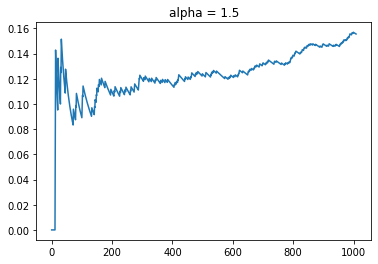

In [8]:
plt.plot(aligned_ctr)
plt.title("alpha = "+str(alpha_input))

Text(0.5, 1.0, 'alpha = 1.0')

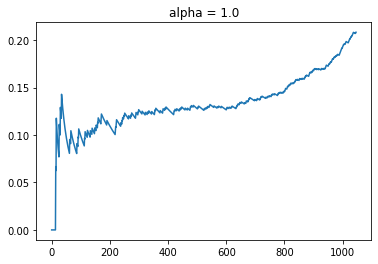

In [8]:
alpha_input = 1.0
data_path = "../data/news_dataset.txt"
aligned_time_steps, cum_rewards, aligned_ctr, policy = ctr_simulator(K_arms = 10, d = 100, alpha = alpha_input, data_path = data_path)

plt.plot(aligned_ctr)
plt.title("alpha = "+str(alpha_input))

Text(0.5, 1.0, 'alpha = 0.5')

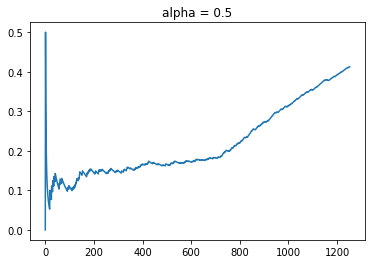

In [9]:
alpha_input = 0.5
data_path = "../data/news_dataset.txt"
aligned_time_steps, cum_rewards, aligned_ctr, policy = ctr_simulator(K_arms = 10, d = 100, alpha = alpha_input, data_path = data_path)

plt.plot(aligned_ctr)
plt.title("alpha = "+str(alpha_input))